In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

***
## Program Flow Overview:

### OBJECTIVE: To create the safest portfolio possible.

### 1) Cleaning and Preparing Data
* Remove invalid tickers
* Remove foreign tickers (i.e. stocks with non USD/CAD currencies)
* Get stock data for the remainining, valid tickers and filter out stocks with low avg. monthly volume
* Convert USD prices to CAD using appropriate day-wise exchange rates
* Store closing prices and daily percentage changes
<br><br>
* Calculate the standard deviation of daily changes for each stock
* Creation of the correlation matrix for the stocks and calculating the average correlation of each stock with all the other stocks
* Calculate and store the number of stocks in different industries.
<br>
### 2) Risk Coefficient and Weighing Stocks
* Assigning a 'risk coefficient' to each stock- a number indicating how risky a stock is (the smaller, the better)
* Risk coefficient factors:
    - Standard deviation
        - Score based on the percentile of the average standard deviation of the stock among calculated standard deviations for ~4000 other stocks (Stocks past the 70th percentile are removed from consideration)
    - Correlation
        - Closer the average correlation is to 0, the better
    - Industry
        - A small weightage is assigned to multi-industry diversification using the proportion of all the valid stocks that are in the same industry as a particular stock
* Top 22 stocks are selected at this point
* Calculate short-term volatility rankings for the stocks based on recent price movements
<br><br>
* Using the risk coefficient and information about short-term movements, FIVE different methods are used to weigh the stocks
    1. Inverse proportion to only the risk coefficient (long-term)
    1. Inverse proportion to the combined effects of risk coefficient and short-term volatility (long-term and short-term)
    1. Equal distribution
    1. Top-heavy Approach: Assigning the two safest stocks the maximum possible weight and equally distributing the rest
    1. Assign the top 3 stocks a weightage of 10% each, the 3 riskiest stocks the minimum weight and equally distribute the rest
 <br>
 
 ### 3) Final Portfolio Creation and Selection
 *  Generate 5 different portfolios using the 5 different weight distributions
 *  To select the final portfolio, we look at the weekly performance of each of the portfolios over the last month
 *  The portfolio with the lowest average weekly change is selected.
 
 ***


# Cleaning and Preparing Data

In [2]:
#Self-explanatory variables
start_date= '2023-01-01'
end_date= '2023-11-25'
tickers_file="Tickers.csv"
valid_currencies=['USD','CAD']
num_ticks=0

In [3]:
#Reading in tickers and storing them in a DataFrame
tickers=pd.read_csv(tickers_file)
tickers=(tickers.T.reset_index().T.reset_index(drop=True).set_axis(['Tickers'], axis=1))
num_ticks= len(tickers)
tickers.head()

,Tickers
0,IBM
1,PPL.TO
2,TD.TO
3,CNR.TO
4,GWO.TO


In [4]:
#Removing invalid tickers; fetching and storing currencies for valid tickers
tickers['Currency']='N.A'
for i in range(0,num_ticks):
    ticker=tickers.loc[i].at['Tickers']
    stock=yf.Ticker(ticker)
    try:
        currency= stock.fast_info['currency']
    except:
        currency='Invalid'  
    tickers.iloc[i,1]=currency

In [5]:
#Removing non-USD/CAD currencies
valid_tickers=tickers[tickers['Currency'].isin(valid_currencies)].reset_index(drop=True)
num_ticks= len(valid_tickers)

In [6]:
#Reading in exchange rate data
rate=yf.Ticker('CADUSD=x').history(start=start_date, end=end_date).reset_index()
rate['Date']=pd.to_datetime(rate['Date']).dt.date
rate=rate[['Date','Close']]
rate.rename(columns= {'Close':'Rate'},inplace=True)
rate.head()

,Date,Rate
0,2023-01-02,0.739202
1,2023-01-03,0.737517
2,2023-01-04,0.731310
3,2023-01-05,0.741559
4,2023-01-06,0.737469


In [7]:
#Function to convert closing prices from USD to CAD
def convert_to_CAD(data):
    data=pd.merge(rate,data)
    data[data.columns[2]]/=data.Rate
    data=data.drop(columns=['Rate'])
    return data

In [8]:
#Function that checks for minimum avg. monthly volume requirements and returns stock data if it is a valid stock or returns a string 'Invalid'
def check_volume_return_data(ticker):   
    
    stock=yf.Ticker(ticker)
    stock_data=stock.history(start=start_date, end=end_date).reset_index()
    stock_data['Date']=pd.to_datetime(stock_data['Date'])
    stock_data=stock_data[['Date','Close','Volume']]

    monthly_trading_days= stock_data[['Date']].groupby(stock_data.Date.dt.month).nunique() #Calculating no. of trading days in each month
    valid_months_list= monthly_trading_days[monthly_trading_days.Date>=18].index.values.tolist() #Removing months with <18 trading days
    stock_data_copy= stock_data[stock_data.Date.dt.month.isin(valid_months_list)]

    monthly_average_volume= stock_data_copy[['Volume']].sum()/len(valid_months_list)    #Calculating monthly avg. volume
      
    if (monthly_average_volume[0]>=150000): #Checking eligibiliy
        stock_data['Date']=stock_data['Date'].dt.date
        stock_data=stock_data[['Date','Close']]
        if (stock.fast_info['currency']=='USD'): #Converting USD prices to CAD
            stock_data= convert_to_CAD(stock_data)
        stock_data['Change']=stock_data['Close'].pct_change()*100 #Calculating daily percentage change
        stock_data.rename(columns= {'Close': ticker+" Close", 'Change':ticker},inplace=True)
        return stock_data #Returning closing prices and daily changes for the stock
    else:
        return 'Invalid'

In [9]:
#Creating a DataFrame with dates as a starting point to store all stock information
dates_series=pd.to_datetime(pd.date_range(start=start_date, end=end_date))
dates=pd.DataFrame({'Date':dates_series})
dates['Date']=dates['Date'].dt.date
total_data=dates

In [10]:
valid_stocks=list()
for j in range (0, num_ticks): #Fetching and storing data for eligible stocks
    ticker= valid_tickers.loc[j].at['Tickers']
    data= check_volume_return_data(ticker)
    
    if isinstance(data, pd.DataFrame): #Checking if the stock is eligible
        total_data=pd.merge(total_data,data) #Adding stock data to the DataFrame
        valid_stocks.append(ticker)

total_data=total_data.set_index('Date',drop=True)
num_valid_stocks= len(valid_stocks)
total_data.head()

,IBM Close,IBM,PPL.TO Close,PPL.TO,TD.TO Close,TD.TO,CNR.TO Close,CNR.TO,GWO.TO Close,GWO.TO,...,SPG Close,SPG,CSCO Close,CSCO,CVS Close,CVS,OTEX.TO Close,OTEX.TO,SU.TO Close,SU.TO
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,182.846568,NaN,43.029846,NaN,84.689217,NaN,160.412781,NaN,30.266724,NaN,...,151.911766,NaN,63.068615,NaN,122.035734,NaN,40.335373,NaN,39.817890,NaN
2023-01-04,185.766528,1.596946,42.905815,-0.288244,85.790459,1.300333,160.580200,0.104368,30.842867,1.903553,...,157.919614,3.954827,63.590618,0.827674,121.839749,-0.160597,41.120113,1.945539,38.756855,-2.664720
2023-01-05,181.284715,-2.412605,43.163422,0.600400,84.384224,-1.639151,158.088531,-1.551666,31.255768,1.338724,...,150.929557,-4.426339,61.828049,-2.771743,118.157036,-3.022588,40.070526,-2.552491,39.673206,2.364359
2023-01-06,185.636126,2.400318,43.802666,1.480986,84.345154,-0.046300,161.949142,2.442056,31.966347,2.273433,...,153.640887,1.796421,64.080699,3.643411,120.323043,1.833160,40.198048,0.318243,40.666721,2.504247
2023-01-09,183.736986,-1.023044,44.184303,0.871266,84.081490,-0.312602,162.313522,0.224996,32.167995,0.630816,...,151.523624,-1.378059,63.833029,-0.386498,119.073370,-1.038599,40.482517,0.707670,40.695656,0.071150


In [11]:
corr_df=total_data.corr() #Correlation matrix for the DataFrame
corr_df.head()

,IBM Close,IBM,PPL.TO Close,PPL.TO,TD.TO Close,TD.TO,CNR.TO Close,CNR.TO,GWO.TO Close,GWO.TO,...,SPG Close,SPG,CSCO Close,CSCO,CVS Close,CVS,OTEX.TO Close,OTEX.TO,SU.TO Close,SU.TO
IBM Close,1.000000,0.151547,0.058026,0.148468,0.084295,0.103110,-0.495417,0.041418,0.584981,0.127623,...,0.473808,0.110878,0.701686,-0.051117,-0.181302,0.082360,-0.069301,-0.021832,0.646494,0.104147
IBM,0.151547,1.000000,-0.085231,0.243105,-0.074055,0.293337,-0.051610,0.137950,0.104963,0.239591,...,0.023818,0.450829,0.119284,0.372491,-0.102766,0.280415,0.130832,0.126523,-0.075797,0.094408
PPL.TO Close,0.058026,-0.085231,1.000000,0.146341,0.510310,0.117710,0.435192,0.086091,-0.383867,0.208749,...,0.468142,0.089460,-0.405581,-0.064233,0.698467,-0.032753,-0.581127,0.126623,0.370702,0.085503
PPL.TO,0.148468,0.243105,0.146341,1.000000,0.015421,0.486114,0.025081,0.444687,0.030913,0.320596,...,0.075630,0.406673,0.105088,0.205298,0.030473,0.159272,-0.031861,0.185553,0.110517,0.638474
TD.TO Close,0.084295,-0.074055,0.510310,0.015421,1.000000,0.115380,0.304368,0.007274,-0.189996,0.129378,...,0.758167,-0.013893,-0.253454,0.021162,0.672109,0.004166,-0.388719,0.011307,0.246318,0.134045


In [12]:
#Calculating and storing the standard deviation of daily percent change for each stock
std_df= pd.DataFrame(columns=['Std. Dev.'])
for stock in valid_stocks:
    std= total_data[stock].std()
    std_df.loc[stock]=std
std_df.head()

,Std. Dev.
IBM,1.092605
PPL.TO,1.040694
TD.TO,1.072652
CNR.TO,1.076779
GWO.TO,0.889720


In [13]:
#Calculating and storing the average correlation of the stock with all the other valid stocks
corr_score=pd.DataFrame(columns=['Average Correlation'])
for stock1 in valid_stocks:
    total_corr=0
    for stock2 in valid_stocks:
        corr=corr_df.loc[stock1+" Close",stock2+ " Close"]
        total_corr+=corr
    avg_corr= total_corr/(num_valid_stocks)
    corr_score.loc[stock1,'Average Correlation']=avg_corr
corr_score.head()

,Average Correlation
IBM,0.201924
PPL.TO,0.131197
TD.TO,0.160295
CNR.TO,0.036969
GWO.TO,0.149479


In [14]:
#Storing the number of valid stocks per industry
industry_df=pd.DataFrame(columns=['Count'])
num_industries=0
for ticker in valid_stocks:
    stock=yf.Ticker(ticker)
    try:
        industry= stock.info['industry']
    except:
        industry='N.A'
    if industry!='N.A':
        if industry in industry_df.index:
            industry_df.loc[industry,'Count']+=1
        else:
            num_industries+=1
            industry_df.loc[industry,'Count']=1
industry_df.head()

,Count
Information Technology Services,1
Oil & Gas Midstream,1
Banks - Diversified,2
Railroads,2
Insurance - Life,1


# Risk Coefficient and Weighing Stocks

The average standard deviation of daily changes of a stock does not necessarily give us a full picture on its own. To better understand the value of avg. standard deviation of a stock and to help assign it a score, we calculated the average standard deviation of daily changes for close to 4000 stocks. We assign the stock's standard deviation score based on which percentile it lies in amongst these stocks. The data for the standard deviation is stored in "STD_mega.csv" which has been attached alongside this code.

The graph for that data is attached below and we see that the value for std. deviation rises relatively steeply heading past the 70th percentile. We decided this was a good cut-off point in the sense that any stock past the 70th percentile was instantly rejected.

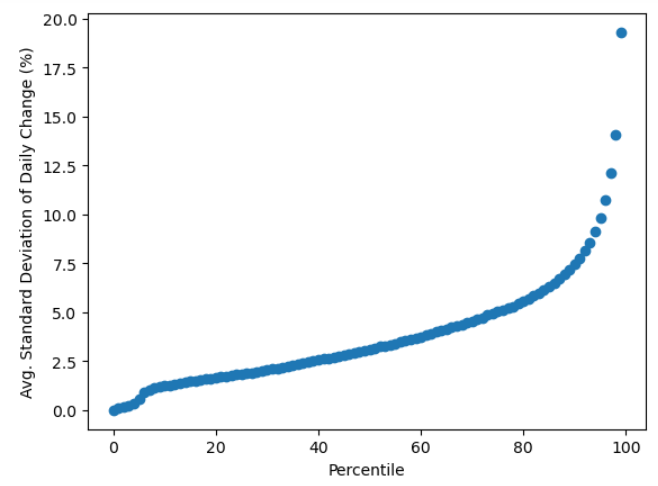

In [15]:
std_df_mega=pd.read_csv("STD_mega.csv") #Reading in the file containing average standard deviations 
std_df_mega.head()

,Unnamed: 0,Std. Dev.
0,AAPL,1.397840
1,MSFT,1.345873
2,GOOG,1.846390
3,GOOGL,1.828692
4,AMZN,2.347135


In [16]:
quantile_df=pd.DataFrame(columns=['Value'])
for i in range (0,101):
    quantile=i/100
    quantile_df.loc[i,'Value']=std_df_mega['Std. Dev.'].quantile(quantile) #Creating a DataFrame to store the cut-offs for each integer percentile value
quantile_df.head()

,Value
0,0.0
1,0.136392
2,0.179693
3,0.24838
4,0.350028


In [17]:
#Calculating and storing risk coefficients
risk_coefficients=pd.DataFrame(columns=['STD','Corr','Industry','Overall'])
for stock in valid_stocks:
    std= std_df.loc[stock,'Std. Dev.']
    for i in range (0,100):
        if ((std>=quantile_df.loc[i,'Value'])&(std<quantile_df.loc[i+1,'Value'])):
            std_score= (i+1)/100 #The standard deviation score is simply the percentile of the stock
    avg_corr_score= 1-abs(corr_score.loc[stock, 'Average Correlation'])  #Correlation score
    try:
        industry= yf.Ticker(stock).info['industry']
    except:
        industry='N.A'
    if industry!='N.A':    
        industry_score= (num_industries-industry_df.loc[industry,'Count'])/(num_industries) #Industry score is the proportion of stocks that are not in the same industry as this one
    else:
        industry_score=1    
    total_risk_score= 100*(0.7*std_score+ 0.25*avg_corr_score+ 0.05*industry_score)**2 #Formula for risk coefficient/risk score
    
    risk_coefficients.loc[stock]=[std_score, avg_corr_score, industry_score, total_risk_score]
risk_coefficients.head()

,STD,Corr,Industry,Overall
IBM,0.08,0.798076,0.944444,9.165219
PPL.TO,0.07,0.868803,0.944444,9.823399
TD.TO,0.08,0.839705,0.888889,9.633004
CNR.TO,0.08,0.963031,0.888889,11.641891
GWO.TO,0.06,0.850521,0.944444,9.111487


__Note on risk coefficient formula:__<br><br>
The weighting of the various parameters in the risk coefficient formula was done using trial-and-error. It was eventually multiplied by 10 and squared to ensure that the ratio of the risk coefficients of two stocks better reflects their weight in the overall portfolio.

Backpropagation and ML in general offers useful alternatives to this manual method but it was (unfortunately) implausible to implement these due to time constraints and relative inexperience.

In [18]:
truncated_risk_coefficients=risk_coefficients[risk_coefficients.STD<0.7] #Removing stocks past the 70th percentile as explained earlier
if(len(truncated_risk_coefficients)>=10): #Ensuring we have atleast 10 stocks
    risk_coefficients=truncated_risk_coefficients
risk_coefficients=risk_coefficients.sort_values('Overall')
if(len(risk_coefficients)>=22):
    risk_coefficients= risk_coefficients.head(22)
final_candidate_stocks= risk_coefficients.index.tolist()

We create a list containing the standard deviations of the percentage returns of each stock in the past 20 days. This is the list of short-term standard deviations

We then create a dataframe "fulldata" that includes the risk coefficients and the short-term standard deviations. Then, we rank each stock based on its risk coefficients and short-term standard deviation. The lower the risk coefficients and short-term standard deviations, the higher the rank for the stock. In the end, we get an overall rank for every stock which is calculated by adding a stock's risk coefficient rank to its short-term standard deviation rank.


In [19]:
#Short-term standard deviations
shortterm_std = [] #List containing the standard deviations of the percentage returns of each stock in the past 20 days
for i in range(len(risk_coefficients)):
    arr = total_data[risk_coefficients.index[i]].iloc[len(total_data)-20:]
    shortterm_std.append(arr.std()) 

In [20]:
#Ranking stocks based on risk coefficient, short-term volatility and both.
fulldata  = pd.DataFrame()
fulldata['risk'] = risk_coefficients['Overall']
fulldata['shortterm_risk'] = shortterm_std


rankrisk = []
for i in range(len(fulldata)):
    numhigher = 0
    for j in range(len(fulldata)):
        if fulldata.iloc[j].iloc[0] < fulldata.iloc[i].iloc[0]:
            numhigher+=1
    rankrisk.append(numhigher+1)

rankreturns = []
for i in range(len(fulldata)):
    numhigher = 0
    for j in range(len(fulldata)):
        if fulldata.iloc[j].iloc[1] < fulldata.iloc[i].iloc[1]:
            numhigher+=1
    rankreturns.append(numhigher+1)

fulldata['risk_ranking'] = rankrisk
fulldata['shortterm_ranking'] = rankreturns
fulldata['total_ranking'] = fulldata['risk_ranking']+fulldata['shortterm_ranking']

fulldata.sort_values(by=['total_ranking'],inplace=True)
ind = []
for i in range(len(fulldata.index)):
    ind.append(fulldata.index[i])


final = pd.DataFrame()
final['index'] = ind
fulldata.head()

,risk,shortterm_risk,risk_ranking,shortterm_ranking,total_ranking
IBM,9.165219,0.651606,2,3,5
PPL.TO,9.823399,0.647477,4,2,6
TD.TO,9.633004,1.018102,3,5,8
CNR.TO,11.641891,0.640446,8,1,9
GWO.TO,9.111487,1.172769,1,9,10


We then generate five portfolios with the same stocks but different weightings for each stock. In the first portfolio, the weighting for each stock is inversely proportional to its risk coefficient, meaning that a stock with a low risk coefficient will receive a high weight. This makes sense because if the risk coefficient of a stock is low, the stock is relatively safe, which means it is less risky to invest more money into that stock.

The next four portfolios are created by considering both a stock's risk coefficient and its short-term standard deviations. In the real world scenario, short-term performance of stocks should not be considered for long-term investments and our first portfolio will be the best option. However, for competition purposes, since the competition only lasts for a week, we will be considering short-term performance of stocks, and the following portfolios are only generated to hopefully ensure a better result for the competition.


In [21]:
#Weights Method #1: Weight of the stock is inversely proportional to its risk coefficient.
s = (1/fulldata['risk']).sum()
base = 100/(2*len(fulldata))
t = 100-base*len(fulldata)

weight = [0]*len(fulldata)

overflow = 0
i=0
while i<len(fulldata):
    weighting = t*((1/fulldata['risk'].iloc[i])/s)+base
    if weighting > 20:
        overflow += weighting-20
        weight[i] = 20
    else:
        weight[i] = weighting
    i+=1


while overflow>0:
    s1 = 0
    for i in range(len(weight)):
        if weight[i]!=20:
            s1+=weight[i]
    for i in range(len(weight)):
        if weight[i]!=20:
            weight[i] += overflow*(weight[i]/s1)
    overflow=0
    for i in range(len(weight)):
        if weight[i]>20:
            overflow = weight[i]-20
            weight[i]=20


final['risk_proportional'] = weight
final.set_index('index',inplace=True)

In [22]:
#Weights Method #2: Weight of the stock is inversely proportional to its total rank based on risk coefficient AND short-term standard deviation
s = (1/fulldata['total_ranking']).sum()
base = 100/(2*len(fulldata))
t = 100-base*len(fulldata)

weight = [0]*len(fulldata)

overflow = 0
i=0
while i<len(fulldata):
    weighting = t*((1/fulldata['total_ranking'].iloc[i])/s)+base
    if weighting > 20:
        overflow += weighting-20
        weight[i] = 20
    else:
        weight[i] = weighting
    i+=1


while overflow>0:
    s1 = 0
    for i in range(len(weight)):
        if weight[i]!=20:
            s1+=weight[i]
    for i in range(len(weight)):
        if weight[i]!=20:
            weight[i] += overflow*(weight[i]/s1)
    overflow=0
    for i in range(len(weight)):
        if weight[i]>20:
            overflow = weight[i]-20
            weight[i]=20


final['total_proportional'] = weight

In [23]:
#Weights Method #3: All stocks are equally weighted
all_equal = [100/len(final)]*len(final)
final['all_equal'] = all_equal

In [24]:
#Weights Method #4: Two safest stocks are given maximum weight, with the rest distributed evenly
top_heavy = [20,20] + ([60/(len(final)-2)]*(len(final)-2))
final['top_heavy'] = top_heavy

In [25]:
#Weights Method #5: Top 3 stocks receive 10% weight, worst 3 stocks receive minimum weight, with the rest distributed evenly.
balanced = [10,10,10] + ([(70-300/(2*len(final)))/(len(final)-6)]*(len(final)-6)) + [100/(2*len(final)), 100/(2*len(final)), 100/(2*len(final))]
final['balanced'] = balanced

In [26]:
final.head()

,risk_proportional,total_proportional,all_equal,top_heavy,balanced
index,,,,,
IBM,5.501066,9.467550,4.545455,20.0,10.000000
PPL.TO,5.284763,8.268413,4.545455,20.0,10.000000
TD.TO,5.344296,6.769492,4.545455,3.0,10.000000
CNR.TO,4.814276,6.269851,4.545455,3.0,3.948864
GWO.TO,5.520104,5.870139,4.545455,3.0,3.948864


 # Final Portfolio Creation and Selection

In [27]:
closing_date="2023-11-24"
day_after_closing="2023-11-25"
investment=750000
trading_fee=4.95

In [28]:
#Function that generates a portfolio with the required specifications using a particular method of weighing the stocks
def generate_portfolio(risk_df, weights_df, weighting_system):
    final_portfolio=pd.DataFrame(columns=['Ticker','Price (CAD)','Currency','Shares','Value','Weight'])
    final_portfolio['Ticker']=weights_df.index
    rate=yf.Ticker('CADUSD=x').history(start=closing_date, end=day_after_closing).reset_index().loc[0,'Close'] #Exchange Rate on the closing date
    for i in final_portfolio.index:
        ticker=final_portfolio.loc[i,'Ticker']
        stock=yf.Ticker(ticker)
        currency=stock.info['currency']
        final_portfolio.loc[i,'Currency']= currency
        price=stock.history(start= closing_date, end=day_after_closing).reset_index().loc[0,'Close'] #Stock Price
        if currency=='USD': #Converting to CAD
            price/=rate
        final_portfolio.loc[i,'Price (CAD)']=price

        weight= final.loc[ticker,weighting_system] #Assigning Weight
        value=investment*weight/100 #Calculating Value
        shares= (value-trading_fee)/price #Number of Shares
        final_portfolio.loc[i,'Shares']=shares
        final_portfolio.loc[i,'Value']=value
        final_portfolio.loc[i,'Weight']=weight
    final_portfolio.index+=1 #We need indexes to go from 1 to the number of stocks
    return final_portfolio

In [29]:
#Generating 5 portfolios using the five different weighing strategies
portfolio_riskonly= generate_portfolio(risk_coefficients, final, 'risk_proportional')
portfolio_equal= generate_portfolio(risk_coefficients, final, 'all_equal')
portfolio_topheavy= generate_portfolio(risk_coefficients, final, 'top_heavy')
portfolio_balanced= generate_portfolio(risk_coefficients, final, 'balanced')
portfolio_totalrank= generate_portfolio(risk_coefficients, final, 'total_proportional')

In [30]:
#List of the five candidate portfolios
portfolios_list=[portfolio_riskonly,portfolio_totalrank, portfolio_equal, portfolio_topheavy, portfolio_balanced]

In [31]:
#Function that picks the best portfolio based on average weekly change over the last month
def pick_best_portfolio (portfolios_list, prices):
    best_portfolio_index=0
    lowest_change=100
    week1=datetime.strptime("2023-10-27", '%Y-%m-%d').date()
    week2=datetime.strptime("2023-11-03", '%Y-%m-%d').date()
    week3=datetime.strptime("2023-11-10", '%Y-%m-%d').date()
    week4=datetime.strptime("2023-11-17", '%Y-%m-%d').date()
    week5=datetime.strptime("2023-11-24", '%Y-%m-%d').date()

    ticker_prices=pd.DataFrame()
    ticker_prices.index= [portfolios_list[0]['Ticker']]
    for i in final_candidate_stocks: #Storing prices for each stock at weekly intervals
        ticker_prices.loc[i,'Price_1']=total_data.loc[week1, i+ " Close"]
        ticker_prices.loc[i,'Price_2']=total_data.loc[week2, i+ " Close"]
        ticker_prices.loc[i,'Price_3']=total_data.loc[week3, i+ " Close"]
        ticker_prices.loc[i,'Price_4']=total_data.loc[week4, i+ " Close"]
        ticker_prices.loc[i,'Price_5']=total_data.loc[week5, i+ " Close"]
        
    for i in range(0,5):
        portfolio= portfolios_list[i].copy()
        for j in portfolio.index:
            stock=portfolio.loc[j, 'Ticker']
            price1= ticker_prices.loc[stock,'Price_1'][0]
            price2= ticker_prices.loc[stock,'Price_2'][0]
            price3= ticker_prices.loc[stock,'Price_3'][0]
            price4= ticker_prices.loc[stock,'Price_4'][0]
            price5= ticker_prices.loc[stock,'Price_5'][0]
            
            #Change in value for the stock per week
            portfolio.loc[j,'Week 1 Change']= (price2- price1)*portfolio.loc[j,'Shares']
            portfolio.loc[j,'Week 2 Change']= (price3- price2)*portfolio.loc[j,'Shares']
            portfolio.loc[j,'Week 3 Change']= (price4- price3)*portfolio.loc[j,'Shares']
            portfolio.loc[j,'Week 4 Change']= (price5- price4)*portfolio.loc[j,'Shares']
        
        #Calculating weekly percentage changes for the last month
        week1_change= 100*portfolio['Week 1 Change'].sum()/investment
        week2_change= 100*portfolio['Week 2 Change'].sum()/investment
        week3_change= 100*portfolio['Week 3 Change'].sum()/investment
        week4_change= 100*portfolio['Week 4 Change'].sum()/investment
        average_weekly_change= (abs(week1_change)+ abs(week2_change)+ abs(week3_change)+ abs(week4_change))/4 #Average weekly change for the portfolio
        if (average_weekly_change<lowest_change):
            lowest_change= average_weekly_change
            best_portfolio_index=i
    return portfolios_list[best_portfolio_index] #Return the portfolio with the lowest average weekly change

In [32]:
Portfolio_Final=pick_best_portfolio (portfolios_list,total_data) #Final portfolio is the best portfolio of the lot!!

In [33]:
print(Portfolio_Final)
print()
print('Total Value: ',Portfolio_Final['Value'].sum())
print('Total Weight: ',Portfolio_Final['Weight'].sum())

     Ticker Price (CAD) Currency       Shares     Value Weight
1       IBM  212.519002      USD   705.795947  150000.0   20.0
2    PPL.TO   45.009998      CAD  3332.482906  150000.0   20.0
3     TD.TO   83.349998      CAD   269.886628   22500.0    3.0
4    CNR.TO  157.240005      CAD   143.061875   22500.0    3.0
5    GWO.TO   43.619999      CAD   515.704964   22500.0    3.0
6       CNI  157.930741      USD   142.436171   22500.0    3.0
7    BMO.TO  110.330002      CAD   203.888785   22500.0    3.0
8      COST  809.867506      USD     27.77621   22500.0    3.0
9      AAPL  260.163919      USD    86.464911   22500.0    3.0
10     T.TO   24.059999      CAD    934.95638   22500.0    3.0
11       SO   95.330897      USD   235.968094   22500.0    3.0
12       BK   64.845823      USD   346.900522   22500.0    3.0
13     GOOG  189.292293      USD   118.837643   22500.0    3.0
14    CMCSA   58.313313      USD   385.761825   22500.0    3.0
15     ORCL  159.204376      USD   141.296681   22500.0

In [34]:
Stocks_Final=Portfolio_Final[['Ticker','Shares']]

In [36]:
Portfolio_Final.to_csv('Portfolio_Final'.csv')